In [1]:
%reset -f
%matplotlib inline

In [2]:
import numpy as np
import scipy.io as sio
import sklearn as sk
from sklearn import decomposition

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas as pd

In [3]:
tf.__version__

'0.9.0'

In [4]:
data = sio.loadmat('/Users/jeff/Documents/Python/_projects/cyclingRNN/drakeFeb.mat')

In [5]:
m1 = np.transpose(data['D'][0,0]['M1'], [1, 0, 2, 3])
emg = np.transpose(data['D'][0,0]['EMG'], [1, 0, 2, 3])

m1 = np.reshape(m1, m1.shape[:2]+(4,)) # order = 'C' or 'F'
emg = np.reshape(emg, emg.shape[:2]+(4,)) # order = 'C' or 'F'

print 'M1 shape '+str(m1.shape)
print 'EMG shape '+str(emg.shape)

M1 shape (5092, 113, 4)
EMG shape (5092, 36, 4)


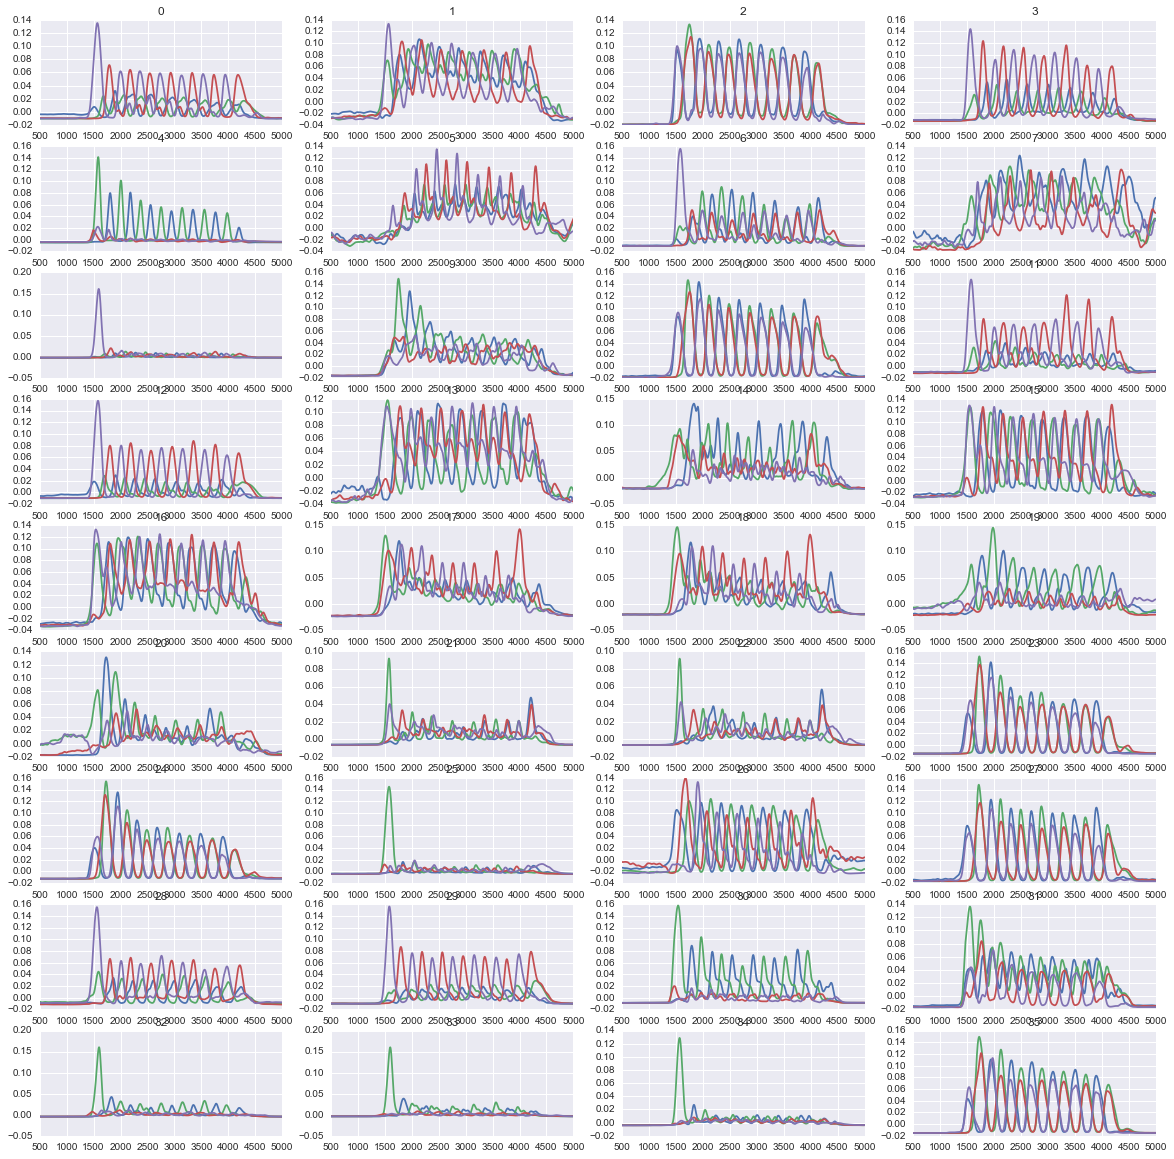

In [6]:
rows = 9
cols = 4
f, ax = plt.subplots(rows,cols, figsize=(20,20))

for i in range(rows):
    for j in range(cols):
        muscle = np.ravel_multi_index((i,j), (rows,cols))
        ax[i,j].plot(emg[:,muscle,:])
        ax[i,j].set_xlim((500,5000))
        ax[i,j].set_title(str(muscle))
plt.show()

In [7]:
times = np.arange(2000,4000, 10)
m1_ = m1[times]
emg_ = 10*emg[times]

In [8]:
pca_emg = sk.decomposition.PCA(n_components=5)
pca_m1 = sk.decomposition.PCA(n_components=5)

pca_emg.fit(np.concatenate([emg_[:,:,i] for i in range(4)]))
pca_m1.fit(np.concatenate([m1_[:,:,i] for i in range(4)]))

PCA(copy=True, n_components=7, whiten=False)

In [9]:
def make_pairgrid(d):
    ''' in: (d1,d2,d3,d4) '''
    df = pd.DataFrame(np.concatenate(d))
    cond_labels = d[0].shape[0]*['fw1'] + d[1].shape[0]*['fw2'] + d[2].shape[0]*['bw1'] + d[3].shape[0]*['bw2']
    df['condition'] = cond_labels
    g = sns.PairGrid(df, hue='condition', diag_sharey=True)
    g.map_diag(plt.hist)
    g.map_offdiag(plt.plot)
    dmax = np.max(np.concatenate(d))
#     for i in range(g.axes.shape[0]):
#         for j in range(g.axes.shape[1]):
#             if i != j:
#                 g.axes[i,j].set_xlim(-dmax,dmax)
#                 g.axes[i,j].set_ylim(-dmax,dmax)
    
    g.add_legend()

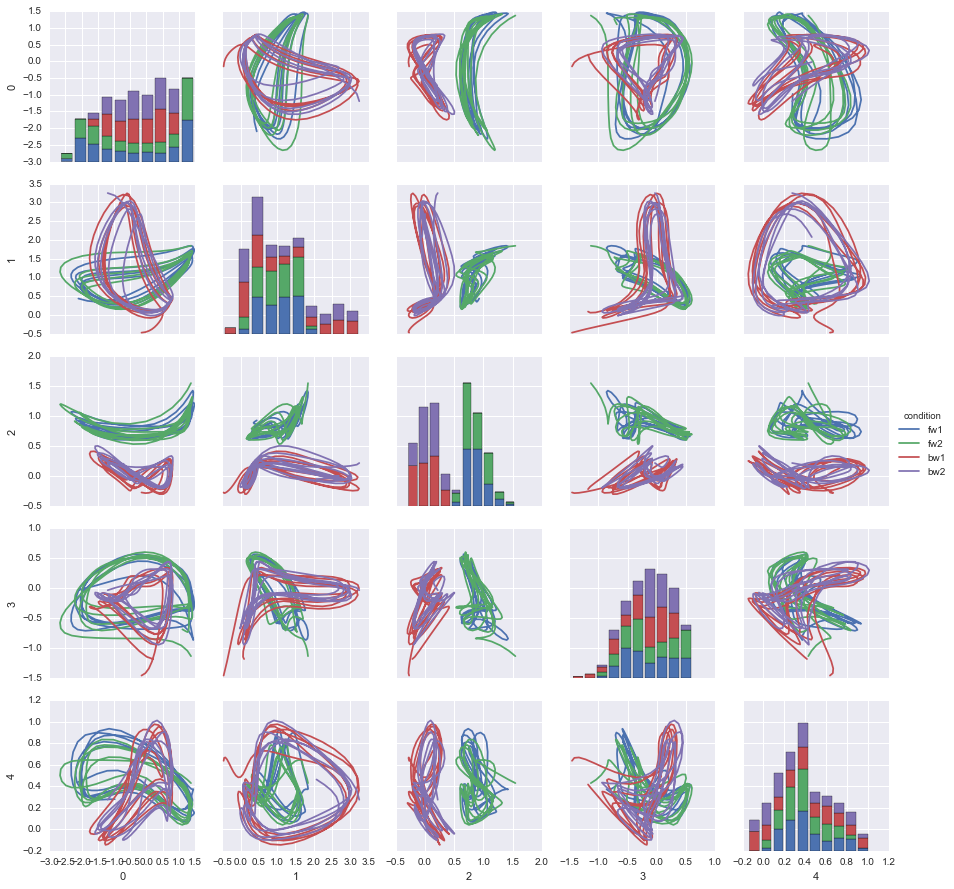

In [10]:
make_pairgrid([np.dot(emg_[:,:,i], pca_emg.components_.T) for i in range(4)])

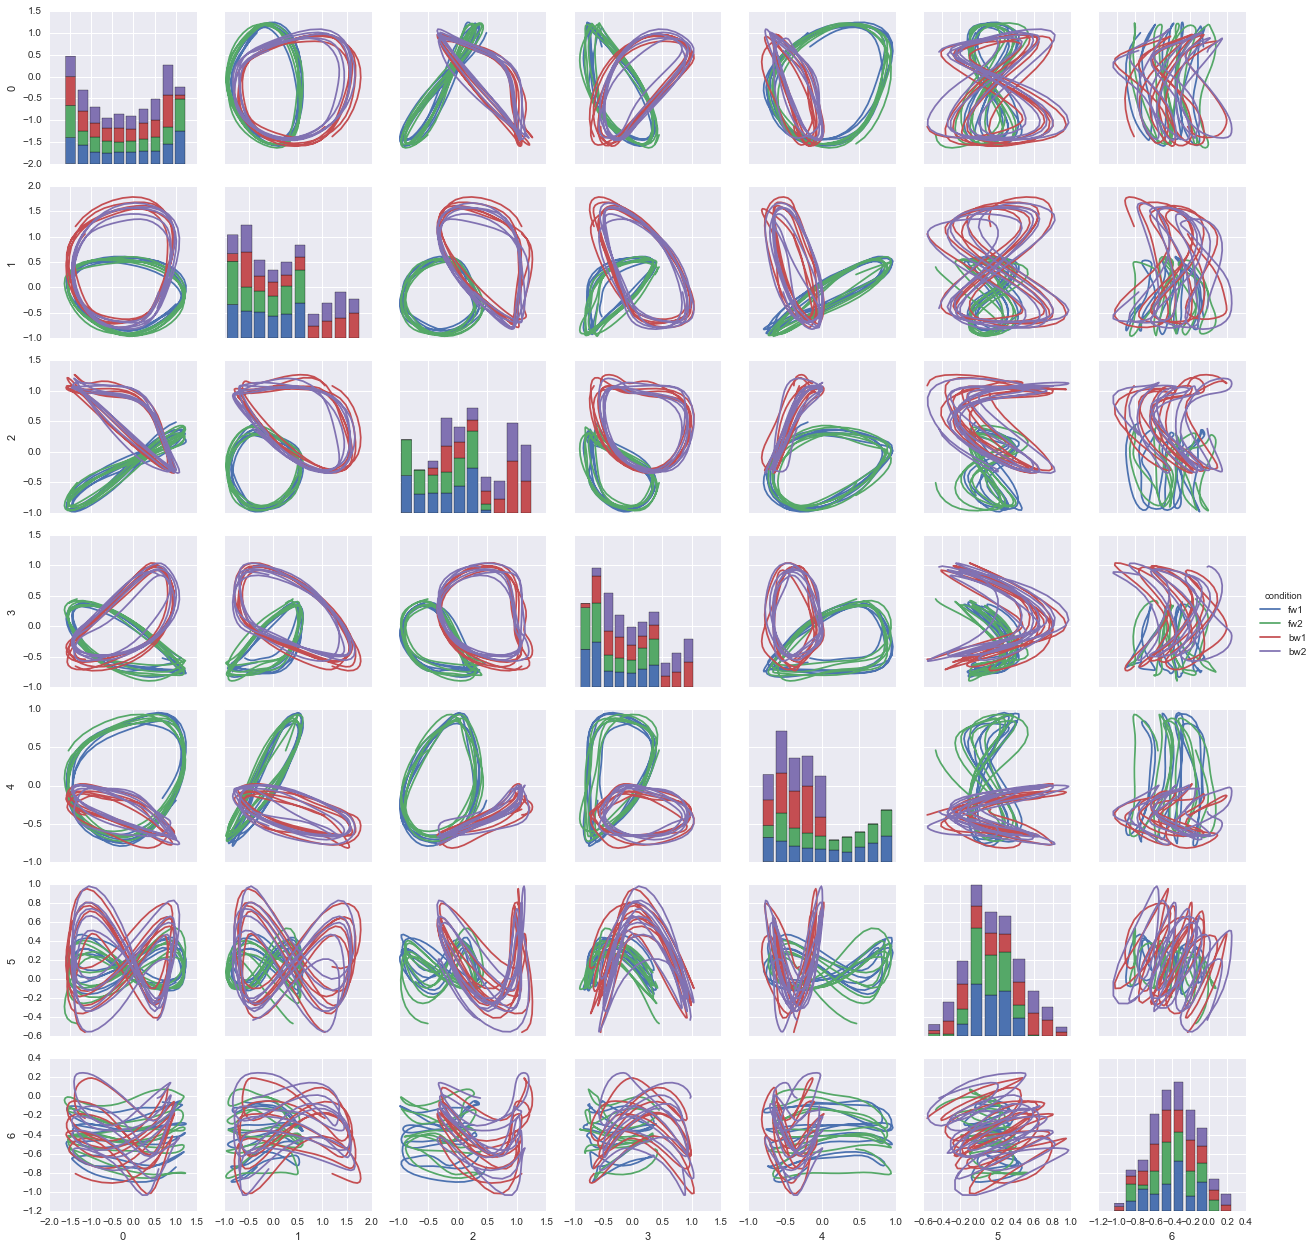

In [11]:
make_pairgrid([np.dot(m1_[:,:,i], pca_m1.components_.T) for i in range(4)])

### RNN

In [12]:
# Some batch-related functions
def hankelize(a, time_steps_):
    """
    Convert size (T,n) matrix to size (num_steps, T-num_steps+1 , n) tensor.
    Different batches can now be selected by a[:,batch_inds,:].
    """
    dims = a.shape
    T_new_ = dims[0] - time_steps_ + 1
    b = np.zeros((T_new_, time_steps_) + dims[1:])
    for i in range(T_new_):
        b[i,:,:] = a[i:i+time_steps_, :]
    inds = range(b.ndim)
    inds[0], inds[1] = inds[1], inds[0]
    b = np.transpose(b, inds) # |
    return b

def get_rand_batch(data_, batch_size_):
    '''
    args:
    return:
    '''
    inds = np.random.choice(data_[0].shape[1], batch_size_)
    for i in range(len(data_)):
        data_[i] = data_[i][:,inds,:]
    return inds, data_

In [13]:
# Time and batch parameters
time_steps = 10 
batch_size = 10
T = emg.shape[0]
T_new = T - time_steps + 1

In [14]:
y_data_h = hankelize(emg_, time_steps)
print y_data_h.shape

(10, 191, 36, 4)


In [15]:
# even partition
y_data_e = y_data_h[:, :y_data_h.shape[1]:time_steps, :]
print y_data_e.shape

(10, 20, 36, 4)


In [16]:
y_data = np.concatenate([y_data_e[:,:,:,i] for i in range(4)], axis=1)
print y_data.shape

(10, 80, 36)


In [17]:
u_data = np.zeros(y_data.shape[:2]+(100,))

In [18]:
print emg_.size
print y_data.size

28800
28800


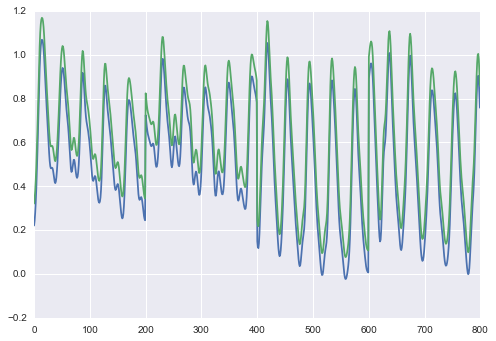

In [19]:
plt.plot(np.concatenate([y_data[:,i,1] for i in range(y_data.shape[1])]))
plt.plot(np.concatenate([emg_[:,1,i] for i in range(4)])+.1)
plt.show()

### graph

In [20]:
# def unpack_sequence(tensor):
#     """Split the single tensor of a sequence into a list of frames."""
#     return tf.unpack(tf.transpose(tensor, perm=[1, 0, 2]))

# def pack_sequence(sequence):
#     """Combine a list of the frames into a single tensor of the sequence."""
#     return tf.transpose(tf.pack(sequence), perm=[1, 0, 2])

def mult_sequence(sequence, M, b):
    return [tf.matmul(sequence[i], M) + b for i in range(len(sequence))]

In [34]:
range(0,9)

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [46]:
tf.reset_default_graph()

m = u_data.shape[-1]
n = u_data.shape[-1]
p = y_data.shape[-1]
c = 4
total_batches = y_data.shape[1]

x0 = tf.Variable(tf.random_normal([total_batches,n], stddev=0.005), name='x0')

C = tf.Variable(tf.random_normal([n,p], stddev=0.5), name='C')
d = tf.Variable(tf.constant(0.1, shape=[1,p]), name='d')

U = tf.placeholder(tf.float32, [time_steps, None, n], name='U')
Y = tf.placeholder(tf.float32, [time_steps, None, p], name='Y')
Inds = tf.placeholder(tf.int32, [None,], name='batch_inds')

cell = tf.nn.rnn_cell.BasicRNNCell(n)
cell = tf.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob=1)
output, _ = tf.nn.dynamic_rnn(cell, U, initial_state=tf.gather(x0, Inds), dtype=tf.float32, time_major=True)

Y_hat = tf.unpack(output)
Y_hat = [tf.matmul(Y_hat[i], C) + d for i in range(time_steps)]
Y_hat = tf.pack(Y_hat)

output_diff = tf.gather(output, range(1,time_steps))-tf.gather(output, range(0,time_steps-1))

Y_fetch = tf.identity(Y)

#Get A matrix
with tf.variable_scope('RNN/BasicRNNCell/Linear', reuse=True):
    A = tf.get_variable('Matrix')

In [47]:
beta = 0.0000
gamma = 0.002
cost = tf.reduce_mean((Y_hat - Y)**2) + beta*tf.nn.l2_loss(A) + gamma*tf.nn.l2_loss(output_diff)
train_op = tf.train.AdamOptimizer(learning_rate=0.0001) # add gradient_noise ? 
opt_op = train_op.minimize(cost)

In [48]:
tf.scalar_summary('loss', cost)
merged_summary_op = tf.merge_all_summaries()

In [49]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())

# tensorboard
summary_writer = tf.train.SummaryWriter('/tmp/tensorflow_logs', graph=sess.graph)

for i in range(10000):
    inds_batch, [y_batch, u_batch] = get_rand_batch([y_data, u_data], batch_size)
    feed_dict = {Y: y_batch, U: u_batch, Inds: inds_batch}
    _, loss_val, summary_str = sess.run([opt_op, cost, merged_summary_op], feed_dict=feed_dict)
    summary_writer.add_summary(summary_str, i)
    
    if i % 500 == 0:
        print 'iter:', '%04d' % (i), \
              'Loss:', '{:.6f}'.format(loss_val)
print 'Finished'

iter: 0000 Loss: 0.090390
iter: 0500 Loss: 0.022547
iter: 1000 Loss: 0.012389
iter: 1500 Loss: 0.006976
iter: 2000 Loss: 0.006579
iter: 2500 Loss: 0.004351
iter: 3000 Loss: 0.003952
iter: 3500 Loss: 0.003517
iter: 4000 Loss: 0.003652
iter: 4500 Loss: 0.002840
iter: 5000 Loss: 0.002816
iter: 5500 Loss: 0.002364
iter: 6000 Loss: 0.002775
iter: 6500 Loss: 0.002385
iter: 7000 Loss: 0.002117
iter: 7500 Loss: 0.002283
iter: 8000 Loss: 0.002637
iter: 8500 Loss: 0.002195
iter: 9000 Loss: 0.001995
iter: 9500 Loss: 0.002183
Finished


In [50]:
feed_dict={Y: y_data, U: np.zeros((time_steps,u_data.shape[1],u_data.shape[-1])), Inds: np.arange(u_data.shape[1])}
y_tf, x_tf = sess.run([Y_hat, output], feed_dict=feed_dict)

In [51]:
def dehankelize(data_):
    data_ = np.concatenate([data_[:,i,:] for i in range(data_.shape[1])])
    data_ = np.reshape(data_, (data_.shape[0]/4, 4, data_.shape[1]), order='F')
    data_ = np.transpose(data_, (0,2,1))
    return data_

In [52]:
y_tf_ = dehankelize(y_tf)
x_tf_ = dehankelize(x_tf)

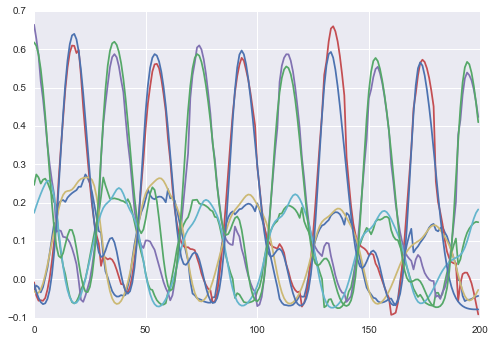

In [53]:
muscle = 0
plt.plot(y_tf_[:,muscle,:])
plt.plot(emg_[:,muscle,:])
plt.show()

In [ ]:
pca_x = sk.decomposition.PCA(n_components=5)
pca_y = sk.decomposition.PCA(n_components=5)

pca_x.fit(np.concatenate([x_tf_[:,:,i] for i in range(4)]))
pca_y.fit(np.concatenate([y_tf_[:,:,i] for i in range(4)]))

PCA(copy=True, n_components=5, whiten=False)

In [ ]:
make_pairgrid([np.dot(x_tf_[:,:,i], pca_x.components_.T) for i in range(4)])

In [ ]:
make_pairgrid([np.dot(y_tf_[:,:,i], pca_y.components_.T) for i in range(4)])